# In this notebook we will explore Quadratic Discriminant Analysis (QDA) in 2D using iris dataset

Credit:

Images are from wikimedia.org

## iris virginica

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/Southern_Blue_Flag_Iris_%28iris_virginica%29_-_Flickr_-_Andrea_Westmoreland.jpg" alt="Smiley face" height="400"  width="400">

## Iris versicolor

<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" alt="Smiley face" height="400"  width="400">

## Iris setosa

<img src="https://upload.wikimedia.org/wikipedia/commons/1/11/Iris_setosa_2.jpg" alt="Smiley face" height="400"  width="400">


## Let's download dataset $\mathcal{D} = \{(\mathbf{x_i}, y_i) \}_{i=1}^{N}$ containing features $\mathbf{x_i}$ of these flowers $y_i$ from UCI machine learning repository

In [0]:
# May have to install seaborn
#!pip install seaborn

In [1]:
import pandas as pd # for doing eploratory data analysis
import seaborn as sns # statistical visualization
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
# to make graphics inline
%matplotlib inline 
sns.set()

C:\Users\18482\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# using pandas read_csv and naming our columns

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_df = pd.read_csv(url, names=names)

# Let's randomly sample 5 observation

In [4]:
iris_df.sample(5)# randomly looking at five samples

,sepal_length,sepal_width,petal_length,petal_width,class
77,6.7,3.0,5.0,1.7,Iris-versicolor
72,6.3,2.5,4.9,1.5,Iris-versicolor
143,6.8,3.2,5.9,2.3,Iris-virginica
0,5.1,3.5,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa


# Statistical Summary and data sanity check


In [5]:
# just to make sure values in different columns are not missing
iris_df.isnull().any()

sepal_length    False
sepal_width     False
petal_length    False
petal_width     False
class           False
dtype: bool

## As per the above output none of the columns have  any null value

In [6]:
# Making sure datatype is also good, so that relevant algebra on columns make sense
iris_df.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
class            object
dtype: object

Class type is object(string). Down the line, we need to convert it to integer label

### The goal in any machine learning task is to do well on future data so let's split our data into train and test using sklearn.

In [7]:
validation_size = 0.32
seed = 3
#np.random.seed(3)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(iris_df,test_size=validation_size,random_state=seed)

In [8]:
print('total training observation {}'.format(train_df.shape))
print('total teasting observation {}'.format(test_df.shape))
train_df.head()

total training observation (102, 5)
total teasting observation (48, 5)


,sepal_length,sepal_width,petal_length,petal_width,class
142,5.8,2.7,5.1,1.9,Iris-virginica
84,5.4,3.0,4.5,1.5,Iris-versicolor
45,4.8,3.0,1.4,0.3,Iris-setosa
35,5.0,3.2,1.2,0.2,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica


# Hence ignoring the class label, we have 4 features for each type of flower

## Let's see how many flowers per class

In [9]:
train_df.groupby('class')['class'].count()

class
Iris-setosa        32
Iris-versicolor    34
Iris-virginica     36
Name: class, dtype: int64

## So we have almost equal examples in each class. Class imbalance is not a big issue but let's still take care of it(We need to estimate class prior probability)

In [10]:
train_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,102.000000,102.000000,102.000000,102.000000
mean,5.857843,3.068627,3.828431,1.219608
std,0.797203,0.425192,1.746531,0.762232
min,4.300000,2.000000,1.100000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.750000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.200000,6.700000,2.500000


As per above summary most the real values featues are clustered around their mean value

## Let's visualize features to find 2 most discriminative one as we want to model class conditional densities using 2D gaussian.

**We can use matplotlib to do scatter plot(kind of Multivariate Plot) to see which features are most discriminative one but seaborn draws attractive statistical graph and we can focus more time on our main objective(find 2 most discriminative one )**

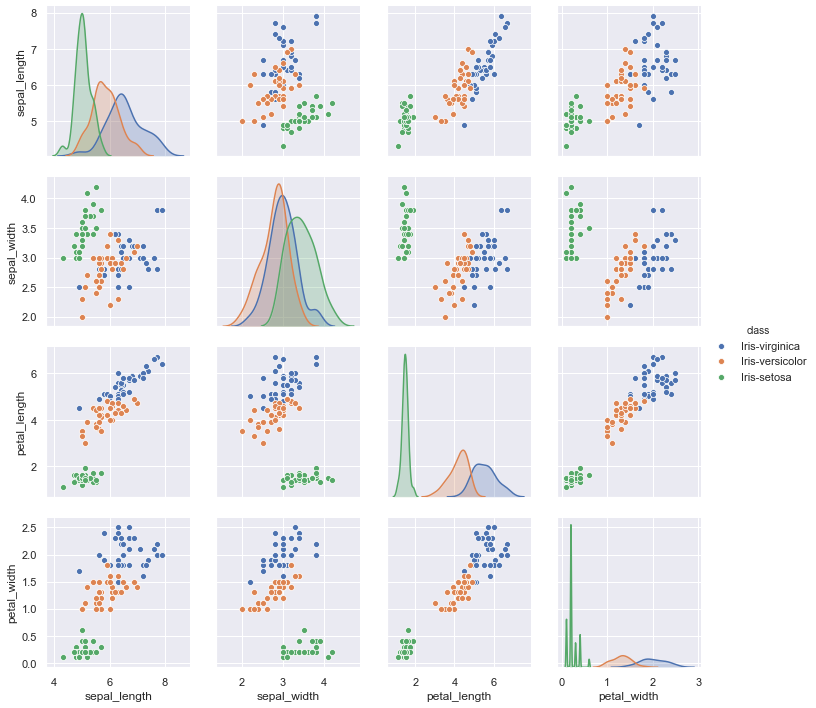

In [12]:
sns.pairplot(train_df, hue="class");

## pairplot,  plots scatter plot off diagonal and histogram(1 d distribution) of various attributes in diagonal.

Scatter plot gives a vague idea of the 2D distribution of the corresponding features. Points gets plotted on top of each other and distribution of the points may not be clear.

# Looks like any two pair of raw features can't classify flowers perfectly

As we want to explore 2D QDA, let's choose **petal length and petal width**


## Following figures gives much better idea of density although it is fitted density

Iris-setosa 



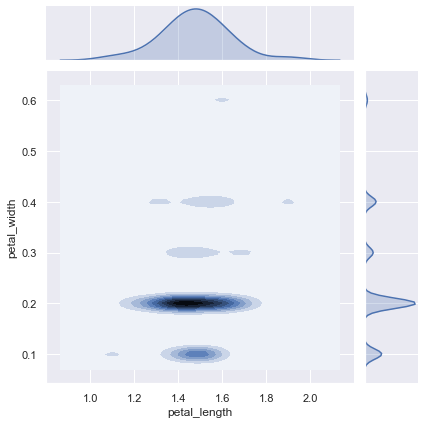

Iris-versicolor 



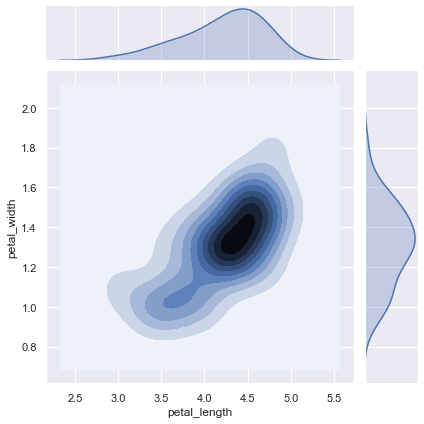

Iris-virginica 



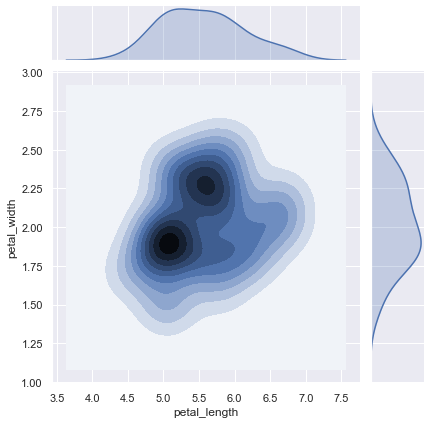

In [13]:
for class_name, per_class_df in train_df.groupby('class'):
    print('{} \n'.format(class_name))
    sns.jointplot(x= 'petal_length', y = 'petal_width',kind='kde' , data = per_class_df)
    plt.show()
#train_df.hist(by= 'class', figsize = (10, 10))

# As we want to work with only 2 features(petal_lenght, petal_width), we need to select only these column from training and test dataset

In [14]:
X_train = train_df[['petal_length', 'petal_width']].values
y_train = train_df['class']
X_test = test_df[['petal_length', 'petal_width']].values
y_test = test_df['class']

In [15]:
# Some debugging information
X_train.shape, y_train.shape, X_test.shape, y_test.shape, y_train.unique()

((102, 2),
 (102,),
 (48, 2),
 (48,),
 array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'], dtype=object))

In [17]:
train_df[['petal_length', 'petal_width']].head()

,petal_length,petal_width
142,5.1,1.9
84,4.5,1.5
45,1.4,0.3
35,1.2,0.2
101,5.1,1.9


In [18]:
# this is how 5 the training record looks now
X_train[0:5]

array([[5.1, 1.9],
       [4.5, 1.5],
       [1.4, 0.3],
       [1.2, 0.2],
       [5.1, 1.9]])

## conversion to numpy looks good

<font color = 'red'> Make sure pandas train_df and X_train agree on values  </font>

For convenience let's convert these string labels to integers
    

In [19]:
# before mapping
y_train.head()

142     Iris-virginica
84     Iris-versicolor
45         Iris-setosa
35         Iris-setosa
101     Iris-virginica
Name: class, dtype: object

# Mapping class labels to integer in pandas

In [20]:
# creating dictionary of mapping
mapping = {v:k for k, v in enumerate(y_train.unique())}
mapping

{'Iris-virginica': 0, 'Iris-versicolor': 1, 'Iris-setosa': 2}

In [21]:
# after mapping
y_train = y_train.map(mapping)
y_train = y_train.values

In [22]:
y_train

array([0, 1, 2, 2, 0, 1, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2,
       0, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 2, 1,
       1, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 0,
       1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 2, 0, 0], dtype=int64)

In [23]:
# let's do same of test label
y_test = y_test.map(mapping).values
y_test

array([2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 0,
       0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2,
       0, 1, 2, 1], dtype=int64)

# QDA steps
- Let's fit(learn mean and covariance matrix) 2D gaussian to joint distribution of (petal_length, petal_width) for different flower category
- Once we have learned per class mean and covariance matrix, we can build discriminant function for discriminating(classifying) future iris flowers

# From MLE estimate per class mean is empirical mean and covariance matrix is empirical covariance matrix
<font size = 7>
$\mathbf{\mu_c} = \sum_{i=1; y_i = c}^{N} \frac{\mathbf{x_i}}{\#I(y_i ==c)}$ 

$\Sigma_c = \sum_{i=1; y_i =c}^{N} \frac{\mathbf{(x_i -\mu_c) (x_i -\mu_c)^{T}}}{\#I(y_i ==c)}$

<br>
$\pi_c = \frac{N_c}{N}$ where $N_c$ is number of example in class $c$ and $N$ total number of example.

</font>

In [24]:
X_c = X_train[y_train == 0]
len(X_c)

36

# Calculating the mean, inverse of covariance matrix and class prior
we are storing inverse of covariance matrix as we need inverse matrix in discriminant function

In [25]:
per_class_mean_vector = []
per_class_covariance_matrix = []
per_class_prior = []
for cls_idx in mapping.values():
    #calculate cls_idx mean and covariance for each class data
    X_c = X_train[y_train == cls_idx]
    cls_prior = X_c.shape[0]/y_train.shape[0]
    cls_mean = sum(X_c)/X_c.shape[0]
    cls_cov = np.dot(np.transpose(X_c-cls_mean),(X_c-cls_mean))/X_c.shape[0]
    per_class_mean_vector.append(cls_mean)
    # Let's store inv as we will see later
    # to take a inverse we need to use linalg from numpy
    per_class_covariance_matrix.append(np.linalg.inv(cls_cov))
    per_class_prior.append(cls_prior)
    


# Checking  parameters correctness before we jump into coding discriminant function.

In [26]:
per_class_prior

[0.35294117647058826, 0.3333333333333333, 0.3137254901960784]

In [27]:
train_df.groupby('class')['class'].count()

class
Iris-setosa        32
Iris-versicolor    34
Iris-virginica     36
Name: class, dtype: int64

<font size =5 color="red"> Make sure per_class_prior output and relative frequency matches. In general it is good habit to keep checking your calculation/code. It can save us a lot of time and trouble. </font>

# We want to classify(discriminate) example in test set i.e we want to evaluate probablity $P(y=c|x_{test})$, This is our discriminant function.
<font size = 5>
$P(y=c|x_{test}) = \frac{P(x_{test}|y=c) P(y=c)}{P(x_{test})}$
</font>

- For each class discriminant function scaling by same value, adding a constant or taking log doesn't matter.
- On right hand side, we have modelled $P(x_{test}|y=c)$ with 2 -d gaussian density and have already estimated its paramters(mean, covariane) for each class using MLE

# After some algebraic simplification,  D=2 quadratic discriminant function for $\mathbf{x} \in \mathbb{R}^2$ will look like
<font size = 5>

$g(\mathbf{x}) = -(x- \mu_c)^T \Sigma_C^{-1}( x- \mu_c) + \log (det(\Sigma_c^{-1})) + \log \pi_c $

</font>

# Coding discriminant function  which takes class mean , covariance matrix, class prior and a test example and outputs the value of discriminant function
 
We will use this discriminant function for predicting class label on test sample. We will compare predicted label with test sample label to see how well we did?

In [28]:
def discriminant(mean, cov_inv,prior, x):
    
    score =  -np.dot(np.dot(np.transpose(x-mean),cov_inv),(x-mean))+np.log(np.linalg.det(cov_inv))+np.log(prior)
    return score

In [29]:
# for each example let's calculate this score and store in numpy array

score_mat = np.zeros((len(X_test), len(mapping)))
score_mat.shape

(48, 3)

In [30]:
for idx, test_example in enumerate(X_test):
    for cls, (mean, cov_inv, prior) in enumerate(zip(per_class_mean_vector, per_class_covariance_matrix, per_class_prior)):
        score_mat[idx][cls] = discriminant(mean, cov_inv, prior, test_example)

# based on these discriminant values lets try to predict class labels
The way we build mapping and stored the score, indices 0,1,2 encode class label for different flowers

In [31]:
predicted_label = np.argmax(score_mat, axis=1)
# hence accuracy is
np.mean(predicted_label == y_test)

0.9791666666666666

In [32]:
class quadratic_discriminant_analysis(object):
    
    def __init__(self, prior = None):
        self._prior = prior
        self.per_class_mean_vector = []
        self.per_class_covariance_matrix = []
        self.per_class_prior = []
        self.mapping=[]
    def fit(self, X, y):
        
        self.mapping = np.unique(y)
        for cls_idx in self.mapping:
            X_c = X[y == cls_idx]
            cls_prior = X_c.shape[0]/y_train.shape[0]
            cls_mean = sum(X_c)/X_c.shape[0]
            cls_cov = np.dot(np.transpose(X_c-cls_mean),(X_c-cls_mean))/X_c.shape[0]
            self.per_class_mean_vector.append(cls_mean)
            self.per_class_covariance_matrix.append(np.linalg.inv(cls_cov))
            self.per_class_prior.append(cls_prior)
        
    def _discriminant(self, mean, cov_inv,prior, x):

        return -np.dot(np.dot(np.transpose(x-mean),cov_inv),(x-mean))+np.log(np.linalg.det(cov_inv))+np.log(prior)
    
    def score(self, X, y):

        score_mat = np.zeros((len(X), len(self.mapping)))
        for idx, test_example in enumerate(X):
            for cls, (mean, cov_inv, prior) in enumerate(zip(self.per_class_mean_vector, self.per_class_covariance_matrix, self.per_class_prior)):
                score_mat[idx][cls] = discriminant(mean, cov_inv, prior, test_example)
        predicted_label = np.argmax(score_mat, axis=1)
        return np.mean(predicted_label == y)
        
        

In [33]:
obj = quadratic_discriminant_analysis()
obj.fit(X_train, y_train)
Score = obj.score(X_test, y_test)
print("Accuracy : ",Score)

Accuracy :  0.9791666666666666


# Fitting the QDA using QuadraticDiscriminantAnalysis from sklearn and report accuracy on the test set.


In [34]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model = QuadraticDiscriminantAnalysis()
model.fit(X_train,y_train)
ypred = model.predict(X_test)
Accuracy = np.sum(ypred == y_test) / len(y_test)
print("Accuracy : ", Accuracy)

Accuracy :  0.9791666666666666


## Note we have successfully matched sklearn accuracy

# Let's fit a LinearDiscriminantAnalysis and report accuracy on test set.

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_linear = LinearDiscriminantAnalysis()
model_linear.fit(X_train,y_train)
ypred = model_linear.predict(X_test)
Accuracy = np.sum(ypred == y_test) / len(y_test)
print("Accuracy : ", Accuracy)

Accuracy :  0.9583333333333334


# Side note: One check various parameters learned by QuadraticDiscriminantAnalysis. Let check mean and our mean vector. They must match

In [36]:
model.means_

array([[5.55833333, 2.01388889],
       [4.20882353, 1.31176471],
       [1.478125  , 0.228125  ]])

In [37]:
per_class_mean_vector

[array([5.55833333, 2.01388889]),
 array([4.20882353, 1.31176471]),
 array([1.478125, 0.228125])]

In [38]:
if(np.array_equal(model.means_,per_class_mean_vector)):
    print("Two mean vectors are same.")
else:
    print("wrong.")

Two mean vectors are same.
